# <center> Inference of COVID-19 vaccines effectiveness and uncertainty using Bayesian methods </center>
***
Students: **Federica Benassi** (2019102), **Luca Rinaldi** (2026363)


#####  <center> Abstract </center>

<center> In this study we first performed the Bayesian analysis of the effectiveness of the vaccines currently approved in Europe.
Considering also the updated data coming from the younger population, we have repeated the analysis subsetting the vaccine data by age ranges.
The obtained results are consistent with the ones officially reported by institutions. </center>


#### Packages
***

In [2]:
library('tidyverse')
library('runjags')
library('coda')
library('tidybayes')
library('maps')
library('mapdata')
options(warn = -1)

#### Functions
***

In [3]:
world_map_processing = function() {
# Data importation
world_data = read_csv('owid-covid-data.csv', col_types=cols()) # from Our World in Data

# Data processing: only the useful columns are selected, and the most recent 
# percentage of vaccinated people for each country is taken
a = world_data %>% select(location, date, people_vaccinated_per_hundred) %>% 
                filter(!is.na(people_vaccinated_per_hundred)) %>%
                group_by(location) %>%
                summarise(maxDate = max(date), vacc=people_vaccinated_per_hundred[which.max(date)]) %>% 
                rename(region = location)

# Some editing for matching the countries with the world map data
a = a %>% mutate(region = ifelse(region == 'United States', 'USA', region)) %>%
          mutate(region = ifelse(region == 'United Kingdom', 'UK', region)) %>%
          mutate(region = ifelse(region == 'Czechia', 'Czech Republic', region)) %>%
          mutate(region = ifelse(region == 'Congo', 'Republic of Congo', region)) %>%
          mutate(region = ifelse(region == 'Democratic Republic of Congo', 'Democratic Republic of the Congo', region)) %>%
          mutate(region = ifelse(region == "Cote d'Ivoire", 'Ivory Coast', region)) %>%
          mutate(region = ifelse(region == 'North Macedonia', 'Macedonia', region))

# World map data importation: this format is suitable for plotting with ggplot2
world = map_data('world')

# Vaccines percentage data and geographical data are merged in a single dataframe
world_map = left_join(world, a, by = 'region') 
return(world_map)}

# Final plot
world_map_plotter = function(world_map) {
options(repr.plot.width=20, repr.plot.height=10)
ggplot(data = world_map) + 
    geom_polygon(aes(x = long, y = lat, fill = vacc, group = group), color = "white") +  
    coord_fixed(1.3) + ggtitle('Percentage of vaccinated people per nation (at least one dose), June 2021') +
    theme(plot.title = element_text(color="black", size=16, face="bold", hjust = 0.5),
          legend.key.size = unit(1, 'cm'), #change legend key size
          legend.key.height = unit(1, 'cm'), #change legend key height
          legend.key.width = unit(1, 'cm'), #change legend key width
          legend.title = element_text(size=16), #change legend title font size
          legend.text = element_text(size=16)) +
    labs(fill = 'Percentage') }


infection_rate.mc <- function(data, iter, n.chains, burnin=4000, prior=c('dbeta(2.88,93.12)','dbeta(1.41,66.11)')){
    # data prep
    dataList = list(
        tested = c(rep(1, data[[1]]),
                   rep(0, data[[3]] - data[[1]]),
                   rep(1, data[[2]]),
                   rep(0, data[[4]] - data[[2]])),
        patient = c(rep(2, data[[3]]),rep(1, data[[4]])),
        Ntot = data[[3]] + data[[4]],
        Nclass = 2
    )
    # model prep
    modelString <- paste(
        "model {    
        for ( i in 1:Ntot ) {      
        tested[i] ~ dbern( theta[patient[i]] )}     
        theta[1] ~ ",prior[1],
        " theta[2] ~",prior[2],"       }", sep=''
    )
    # mcmc
    runjags.options(inits.warning=FALSE, rng.warning=FALSE, silent.runjags=TRUE)
    vaccine_chains <- run.jags(modelString ,
                          sample = iter,
                          burnin = burnin,
                          n.chains = n.chains,
                          method = "parallel",
                          monitor = "theta",
                          data = dataList,
                          summarise=FALSE, silent.jags=TRUE)
    return(vaccine_chains)
}

effectiveness <- function(inf_rates, plot=TRUE, title, color){
    vaccine_eff <- tidybayes::tidy_draws(inf_rates) %>%
        select('theta[1]':'theta[2]') %>% rename(Placebo = 'theta[1]', Vaccine = 'theta[2]') %>%
        mutate(diff_rate = (Placebo - Vaccine) / Placebo * 100,
               Placebo_perc = Placebo * 100,
               Vaccine_perc = Vaccine * 100)
    vaccine_eff.coda <- as.mcmc(vaccine_eff)
    eff <- NULL
    eff$median  <- median(vaccine_eff[['diff_rate']])
    eff$mean    <- mean(vaccine_eff[['diff_rate']])
    eff$sd      <- sd(vaccine_eff[['diff_rate']])
    eff$cred.95 <- quantile(vaccine_eff[['diff_rate']], c(0.025,0.975))
    eff$density <- density(vaccine_eff.coda[,'diff_rate'])
    eff$mode    <- eff$density$x[which.max(eff$density$y)]
    eff$title   <- title
    if (plot==TRUE){
        cat(title,'effectiveness statistics:')
        cat('\nMean:\t\t\t',eff$mean)
        cat('\nMode:\t\t\t',eff$mode)
        cat('\nMedian:\t\t\t',eff$median)
        cat('\nStdev:\t\t\t',eff$sd)
        cat('\n95 cred. interval:\t',eff$cred.95[[1]],'\t',eff$cred.95[[2]])
        options(repr.plot.width=16, repr.plot.height=7)
        m <- rbind(c(1,1,1,1,2,2), c(1,1,1,1,3,3))
        layout(m)
        plot(eff$density$x, eff$density$y, type='l',main=paste(title,'effectiveness posterior distribution'),
             ylab='Frequency', xlab='Vaccine effectiveness', cex.main=1.5, cex.lab=1.5, lwd=3)
        hist(vaccine_eff.coda[,'diff_rate'], freq = FALSE, add=TRUE)
        a <- which(eff$density$x > eff$cred.95[[1]])[1]
        b <- which(eff$density$x > eff$cred.95[[2]])[1]-1
        polygon(eff$density$x[(a-1):(b+1)], c(0,eff$density$y[a:b],0), col=color, density=80, lwd=0.7)
        abline(v=eff$mean, lwd=2, lty=2)
        text(eff$mean-0.3, max(eff$density$y)/2, paste('mean=',format(eff$mean, digits=3)), srt=90, cex=2.5)
        plot(1:length(vaccine_eff.coda[,'diff_rate']),vaccine_eff.coda[,'diff_rate'], type='l',
             main='Trace', ylab='', xlab='Iteration', cex.main=1.5, cex.lab=1.5)
        x_ac          <- seq(0,500,10)
        vaccine_eff_ac <- autocorr(vaccine_eff.coda[,'diff_rate'],lags=x_ac)
        plot(x_ac, vaccine_eff_ac, main='Autocorrelation', ylab='', xlab='Lags', cex.main=1.5, cex.lab=1.5)
    }
    return(eff)
}

eff_comparator <- function(listoflist){
    mean.vec <- c()
    low.vec  <- c()
    upp.vec  <- c()
    titl.vec <- c()
    for (i in listoflist){
        mean.vec <- c(mean.vec, i$mean)
        low.vec  <- c(low.vec,  i$cred.95[[1]])
        upp.vec  <- c(upp.vec,  i$cred.95[[2]])
        titl.vec <- c(titl.vec, i$title)
    }

    options(repr.plot.width=14, repr.plot.height=7)
    comparison.bar <- barplot(mean.vec, ylim=c(50,100), xpd=F, names.arg=titl.vec, 
                              density=55, axis.lty=1, las=1, col=c('lightblue','blue','orange','pink','green'),
                              main='Comparison between vaccine effectiveness\nand their credibility interval',
                              ylab='Effectiveness')
    arrows(comparison.bar,upp.vec, comparison.bar, low.vec, angle=90, code=3, length=0.2,
           col=c('lightblue','blue','orange','pink','green'), lwd=4)
    points(comparison.bar,mean.vec, lwd=6, col=c('lightblue','blue','orange','pink','green'))
}

f = function(a) {format(a, digits=6)}

table.maker = function(listoflist) {
    age.list = list(range = c(), mean = c(), cred2.5 = c(), cred97.5 = c(), x=c())
    cat('\t\tMean\t\tMode\t\tMedian\t\tStdev\t\t2.5cred\t\t97.5cred\t\n')
    for (i in listoflist) {
        b = 100
        age.list$mean = c(age.list$mean, i$mean)
        age.list$cred2.5 = c(age.list$cred2.5, i$cred.95[[1]])
        age.list$cred97.5 = c(age.list$cred97.5, i$cred.95[[2]])
        try(b <- as.numeric(sapply(strsplit(i$title, '-'), '[[', 2)), silent=TRUE)
        age.list$range = c(age.list$range, c(as.numeric(sapply(strsplit(i$title, '-'), '[[', 1)), b))
        age.list$x = c(age.list$x, (as.numeric(sapply(strsplit(i$title, '-'), '[[', 1)) + b)/2)
        cat('\n', i$title, '\t\t', f(i$mean), '\t\t', f(i$mode),  '\t\t', f(i$median),  '\t\t', f(i$sd),
            '\t\t', f(i$cred.95[[1]]),  '\t\t', f(i$cred.95[[2]]), sep='')
        }
    return(age.list)
    }

age.comparator <- function(data,color,title){
    plot(data$x,data$mean, ylim=c(50,100), xlim=c(12,100), col=color, lwd=5, xaxt='n',main=title,
         xlab='Age', ylab='Effectiveness', cex.main=2, cex.axis=1.5, cex.lab=1.5)
    axis(1, at=c(data$range[seq(1,20,2)],100), cex.axis=1.5, las=2)
    arrows(data$x, data$cred2.5, data$x, data$cred97.5, code=0, lwd=3, col=color)
    arrows(data$range[seq(1,20,2)],data$cred97.5,data$range[seq(2,20,2)],data$cred97.5, code=0, lwd=3, col=color)
    arrows(data$range[seq(1,20,2)],data$cred2.5,data$range[seq(2,20,2)],data$cred2.5, code=0, lwd=3, col=color)
    for (i in 1:length(data$mean)){
        polygon(seq(data$range[i*2-1],data$range[i*2],length.out=1000), 
                c(data$cred2.5[i],rep(data$cred97.5[i],998),data$cred2.5[i]), density=120, col=color[i], lwd=0.3)
    }
}

## Introduction
***
The COVID-19 pandemic is an ongoing global pandemic that has started in December 2019, when the first case has been detected in Wuhan, China. Its common symptoms include fever, breathing difficulties, cough, headache, loss in smell and taste and, in more severe cases, pneumonia. The currently confirmed cases from the start of the pandemic are over 178 millions, with almost 4 millions of deaths and a global death-to-case ratio of 2.2%. 

Since early 2020, vaccine development has been expedited via unprecedented collaboration in the multinational pharmaceutical industry and between governments: clinical trials started in April 2020, while the first doses started being distributed in United Kingdom and Europe in December 2020. Currently, over 1.69 billions of doses have been distributed, meaning that the 21.6% of world population has received at least one dose of vaccine. Canada and Israel are the top-two countries in number of people vaccinated, with more than 60% of their population. In the graph below the percentage of people vaccinated with at least one dose is displayed for almost all the countries.

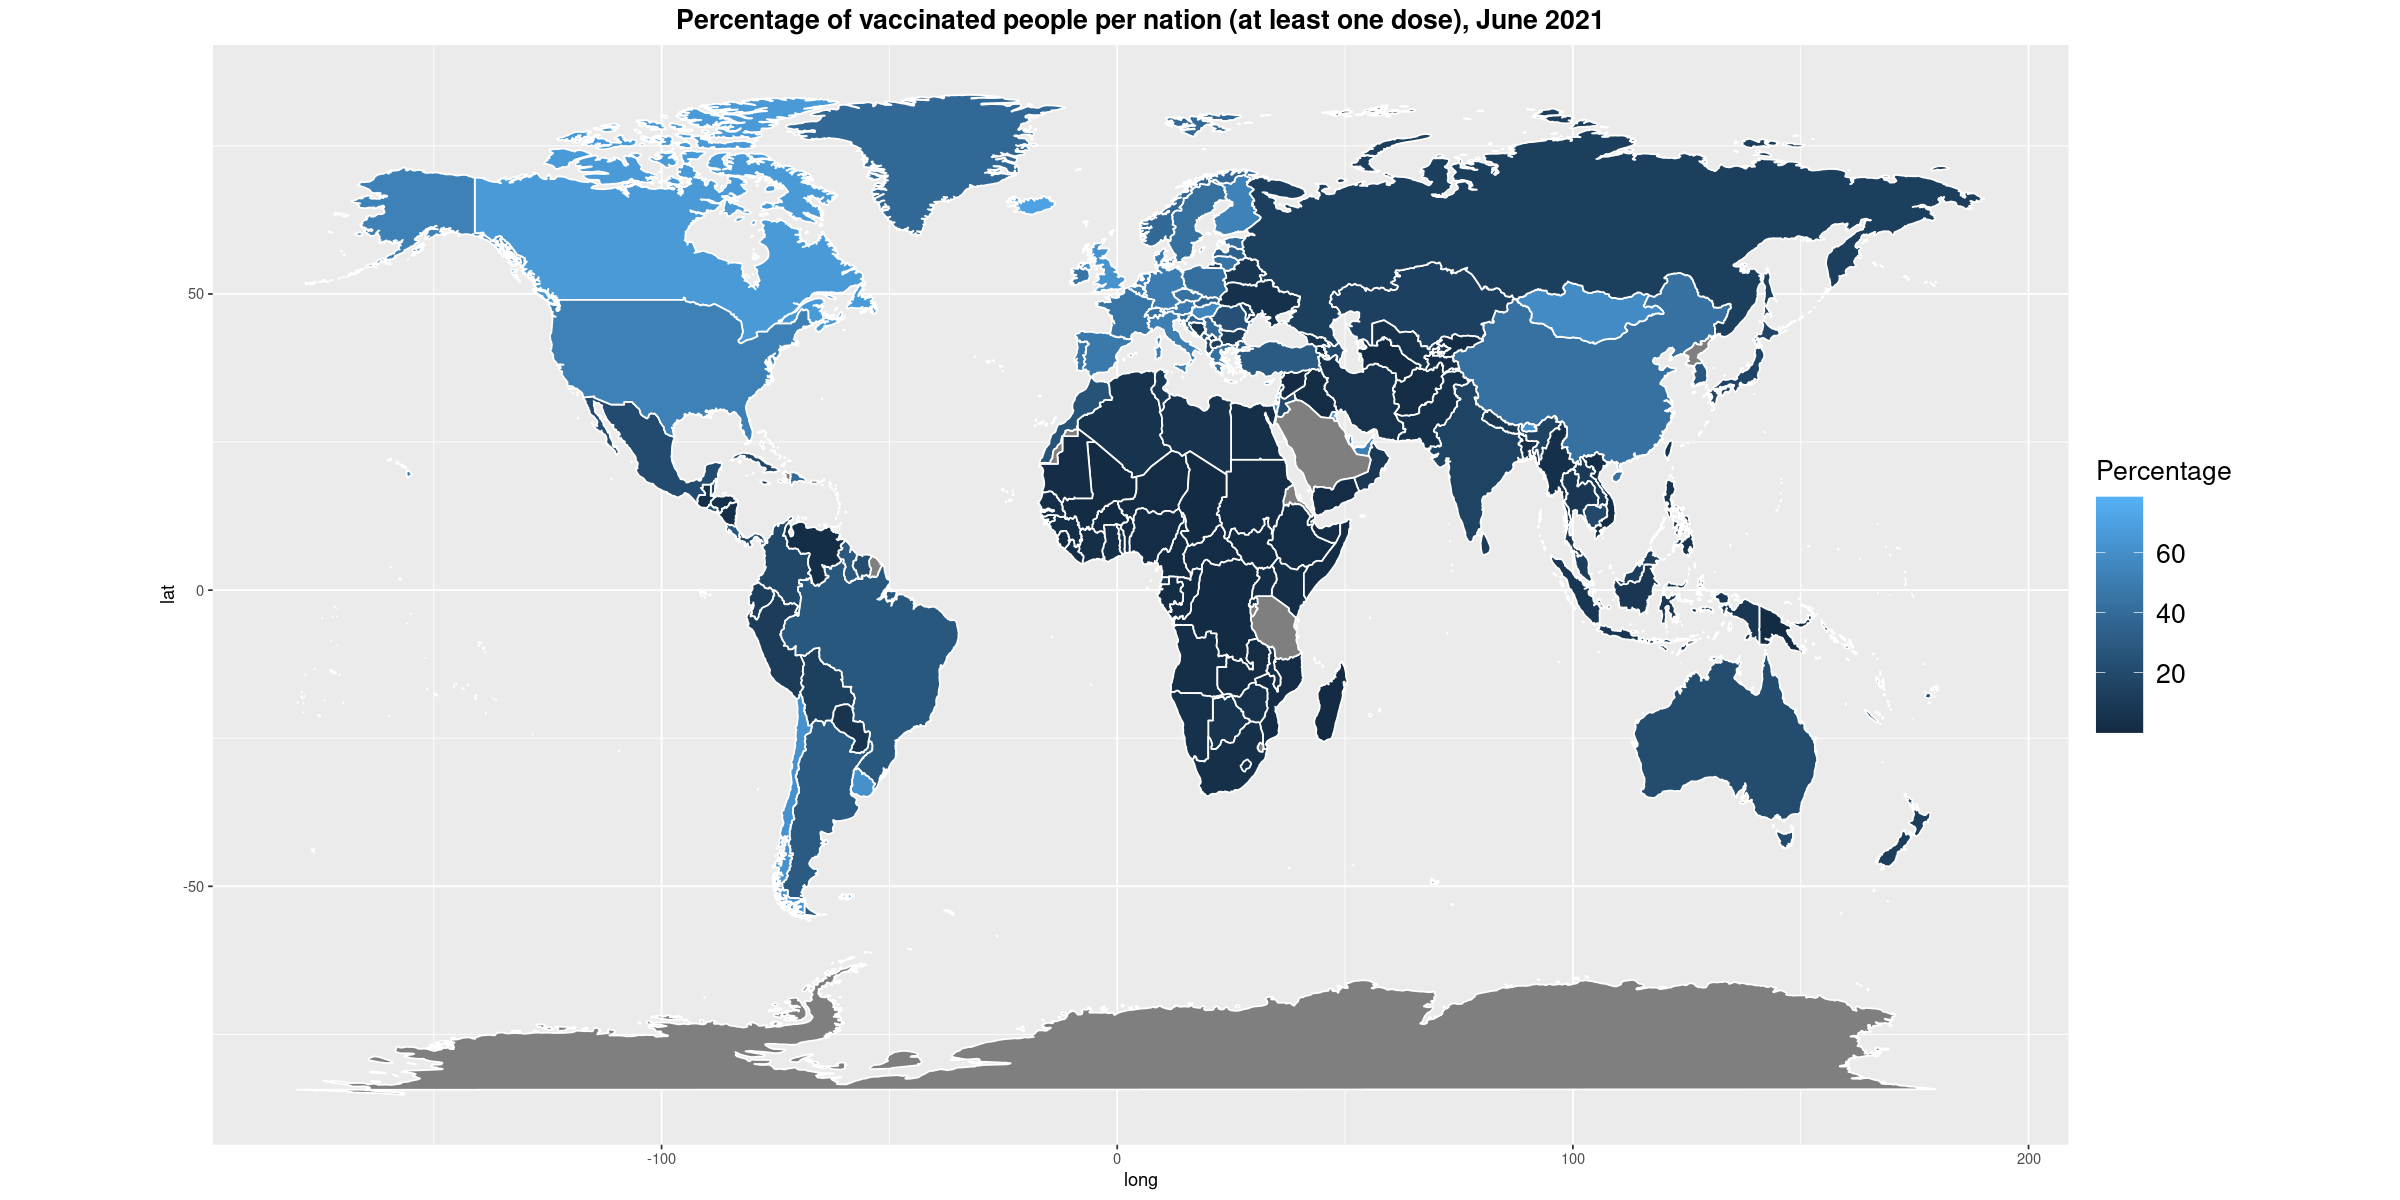

In [4]:
world_map = world_map_processing()

# World map plot
world_map_plotter(world_map)

The European Medicines Agency (EMA) has currently approved four COVID-19 vaccines:
- Comirnaty (BNT162b2), COVID-19 mRNA vaccine, produced by BioNTech/Pfizer;
- COVID-19 Vaccine Moderna, mRNA vaccine, produced by Moderna, Biotech;
- Vaxzevria (previously COVID-19 Vaccine AstraZeneca), produced by AstraZeneca;
- COVID-19 Vaccine Janssen, produced by Janssen-Cilag International NV.

In the first part of our study, we inferred the effectiveness of such vaccines using Bayesian methods and the official data coming from EMA, U.S. Food and Drug Administration (FDA) and the official media channels of the pharmaceutical industries.
In the second part, we evaluated such efficacy as a function of age, including the new studies on adolescents.


### Methods
***

#### Bayesian inference and Markov Chain Monte Carlo methods
***
Statistical inference is the process of using a set of observation data $D$ to infer the parameters $\theta$ of the underlying generative statistical model $M$. Bayesian inference is a method of statistical inference that relies on Bayes' Theorem:

$$
P(\theta | D, M) = \frac{P(D | \theta, M)P(\theta | M)}{P(D | M)}
$$

where: 
- P($\theta$ | D, M) is called **posterior** and it represents the probability distribution of the parameters;
- P(D | $\theta$, M) is called **likelihood** and it describes the probability distribution of getting the observation dataset, given a certain value of the parameters;
- P($\theta$ | M) is called **prior** and it represents the probability distribution of the parameters, given our background information.
- P(D | M) is the **evidence** and it is a normalization constant (integral).

The final goal of Bayesian inference is to find the posterior distribution: often this can be done only through the evaluation of computationally-expensive integrals. Markov Chain Monte Carlo (MCMC) methods have been developed as a faster and computationally cheaper alternative to numeric evaluation of integrals: these methods are based on an approximate random sampling from the target posterior distribution $f$. The most widely used algorithm is the Metropolis-Hastings algorithm: 
- a sample $s$ is randomly drawn from a proposal distribution Q(s|$\theta$) (typically a multivariate Gaussian);
- the Metropolis ratio is evaluated with respect to the current parameter value $\theta_t$:

$$
\rho = min(1, \frac{f(s)}{f(\theta_t)} \frac{Q(\theta_t | s)}{Q(s | \theta_t)})
$$

- If the ratio is $\geq$ 1, the proposed sample is accepted: $\theta_{t + 1} = s$; else, $s$ is accepted with probability $\rho$. If $s$ is not accepted, $\theta_{t + 1} = \theta_{t}$.

The algorithm runs for a certain number of iterations, typically between $10^4$ and $10^6$.
Depending on the inizialization of the chain, the first samples may not be representative of the distribution and they should be discarded: the number of discarded samples is defined by the *burn-in*.

In multiple dimensions, it may be useful to update only small blocks of parameters at each time: this technique is called blockwise Metropolis-Hastings algorithm. In this study we used a special case of such method, called **Gibbs' Sampling**: a multi-dimensional chain is generated by splitting the array of the random variables in subvectors, and sampling each subvector in turn conditionally on the most recent values of all the other elements (that are kept fixed).

All the Markov chain simulations have been performed with JAGS (Just Another Gibbs Sampler), version 4.3.0, which is interfaced with R through the library `runjags`. JAGS provides a cross-platform engine for BUGS (Bayesian inference Using Gibbs Sampling) language: this allows to define the statistical model in BUGS syntax. 

#### Case of study
***
Vaccine effectiveness tests are performed in randomized controlled trials, in which participants are randomly assigned to receive the vaccine or a placebo. These two groups are usually in a variable proportion (usually 1:1 or 2:1). None of the participants or the researchers know what a given person has received. 
After a defined period, the number of occurrences of the disease is compared between the two groups: vaccine effectiveness is defined as the percent reduction in the frequency of illness among vaccinated people and who received the placebo. Given the infection rate of vaccinated people, $p_v$, and who received placebo, $p_p$, the vaccine effectiveness formula will be

$$
VE = 1 - \frac{p_v}{p_p} = \frac{p_p-p_v}{p_p}.
$$

Our target is the inference of $p_v$ and $p_p$, from which $VE$ can be derived. 
For each vaccine, we used the official data coming from EMA, FDA and the producers: these data contain the population sizes and the positive tests to COVID-19 for both vaccine and placebo groups.

The number of people who tested positive to the disease, $y$, follows a binomial distribution with infection rate $p$ and population size $N$:

$$
P(y | p, N) = \binom{N}{y} (p)^{y}(1-p)^{N-y}.
$$

This also represents our likelihood distribution. 

We chose two different beta prior distributions for vaccine and placebo infection rates. 
Assuming a low vaccine efficacy of 30%, from its definition one gets that 

$$
p_v = (1 - VE)p_p = 0.7 p_p
$$ 

Considering all the safety measures adopted during the pandemic (mask, social distancing, handwashing), we assumed a standard probability of infection of $0.03$. This affects all the unvaccinated people, including the ones who received placebo. Thus, from the formula above, we get that the infection rate for vaccinated people will be about $p_v = 0.02$. We chose a variance $\sigma^2$ of 0.0003.

Knowing the mean value and the variance, we can obtain the $\alpha$ and $\beta$ parameters of the Beta distributions: 

$$
\alpha = \mu\left[\frac{\mu}{\sigma^2}(1-\mu) - 1\right] \hspace{1.5cm} 
\beta = (1-\mu)\left[\frac{\mu}{\sigma^2}(1-\mu) - 1\right]
$$

which leads to $p_v$ $\sim$ Beta(1.41, 66.11) and $p_p$ $\sim$ Beta(2.88, 93.12). In the figure below a plot of the prior distributions is shown.


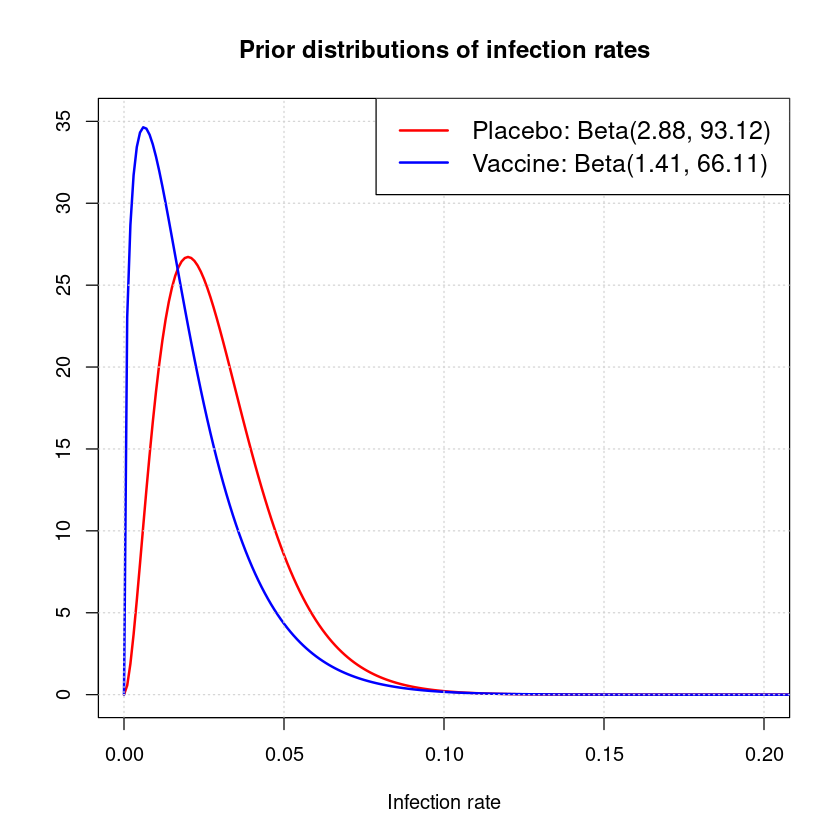

In [5]:
options(repr.plot.width=7, repr.plot.height=7)
p = seq(0,1,0.001)
plot(p, dbeta(p, 2.88, 93.12), type='l', col='red', lwd=2, ylim = c(0,35), xlim=c(0,0.20), 
     main = 'Prior distributions of infection rates', ylab='', xlab='Infection rate')
lines(p, dbeta(p, 1.41, 66.11), type='l', col='blue', lwd=2)
grid()
legend('topright', legend=c('Placebo: Beta(2.88, 93.12)', 'Vaccine: Beta(1.41, 66.11)'), col=c('red', 'blue'), 
       lty=1, lwd=2, cex=1.25)

### Data description
***

#### Comirnaty (Pfizer/BioNTech)
Comirnaty contains messenger RNA (mRNA), a molecule containing instructions for the production of the spike protein of SARS-CoV-2 (the virus causing COVID-19). This triggers an immune response against infection by virus protein. It is given in two injections of 0.3 mL each, 3 weeks apart. 
Pfizer/BioNTech released data about:
- the vaccine efficacy of 7 days after the 2nd dose (and age study $\geq$ 16): source [factsheet FDA](https://www.fda.gov/media/144413/download) and [EMA clinical overview](https://clinicaldata.ema.europa.eu/web/cdp/home) 
- the vaccine efficacy of 6 months after the 2nd dose: source [Pfizer website](https://www.pfizer.com/news/press-release/press-release-detail/pfizer-and-biontech-confirm-high-efficacy-and-no-serious)
- vaccine efficacy for adolescents (12-15 years old): source [Pfizer website](https://www.pfizer.com/news/press-release/press-release-detail/pfizer-biontech-announce-positive-topline-results-pivotal)


|              | vpos| ppos|  vtot|  ptot|
|:-------|----:|----:|-----:|-----:|
|<b>tot_old</b> |    8|  162| 18198| 18325|
|<b>tot_new</b> |   77|  850| 18198| 18325|
|<b>12-15</b>   |    0|   18|  1131|  1129|
|<b>16-64</b>   |    7|  143| 14216| 14299|
|<b>65-74</b>   |    1|   14|  3176|  3226|
|<b>more75</b>  |    0|    5|   804|   812|


#### Moderna
Like Comirnaty, Moderna is a mRNA vaccine. It is given in two injections, 0.5 mL each, 28 days apart.

Moderna released data about:
- vaccine efficacy, by age (14 days after dose 2): source [factsheet FDA](https://www.fda.gov/media/144637/download)
- TeenCOVE (vaccine efficacy for adolescents between 12 and 18 years old): source [Moderna website](https://investors.modernatx.com/news-releases/news-release-details/moderna-announces-teencove-study-its-covid-19-vaccine)

Currently, Moderna is also conducting a research on [vaccine efficacy on kids between 6 months and 12 years of age](https://connect.trialscope.com/studies/0e8fc8e6-5782-46fd-8b03-0994a5ad8b41), but data are not available yet.

|       | vpos| ppos|  vtot|  ptot|
|:------|----:|----:|-----:|-----:|
|<b>tot</b>    |   11|  185| 14134| 14073|
|<b>12-17</b> |    0|    4|  2488|  1244|
|<b>18-64</b>  |    7|  156| 10551| 10521|
|<b>more65</b> |    4|   29|  3583|  3552|


#### Vaxzevria

Vaxzevria vaccine is made up of a chimpanzee adenovirus that is unable to replicate and that has been modified to contain the genetic information for producing the SARS-CoV-2 spike protein. It is given in two doses, 0.5 mL each, 4 to 12 weeks apart.

AstraZeneca released data about:
- vaccine efficacy after 14 days from dose 2: source [Oxford University and collaborations](https://www.thelancet.com/action/showPdf?pii=S0140-6736%2821%2900432-3)

|    | vpos| ppos| vtot| ptot|
|:---|----:|----:|----:|----:|
|<b>tot</b> |   84|  248| 8597| 8581|


#### Janssen
Like Vaxzevria, Janssen vaccine is based on viral vector technology and it contains an adenovirus that encodes the SARS-CoV-2 spike protein. It is given in a single dose of 0.5 mL.

Janssen released data about:
- vaccine efficacy (14 days after dose 2): source [factsheet FDA](https://www.fda.gov/media/146304/download)

Currently, Janssen is extending the [clinical trial to adolescents between 12 and 17 years old](https://www.janssen.com/johnson-johnson-expands-phase-2a-clinical-trial-covid-19-vaccine-candidate-include-adolescents), but data are not available yet.

|       | vpos| ppos|  vtot|  ptot|
|:------|----:|----:|-----:|-----:|
|<b>tot</b>    |  116|  348| 19630| 19691|
|<b>18-59</b>  |   95|  260| 12830| 12881|
|<b>more60</b> |   21|   88|  6800|  6810|

#### Code to store the data

In [6]:
#Comirnaty
rownames = c('tot_old', 'tot_new', '12-15', '16-64', '65-74', 'more75')
vpos = c(8, 77, 0, 7, 1, 0)
ppos = c(162, 850, 18, 143, 14, 5)
vtot = c(18198, 18198, 1131, 14216, 3176, 804)
ptot = c(18325, 18325, 1129, 14299, 3226, 812)
pfizer.df = data.frame(row.names = rownames, vpos=vpos, ppos=ppos, vtot=vtot, ptot=ptot)

#Moderna
young.pop= 3732
vratio = 2/3
moderna.df <- data.frame(
              row.names=c('tot', '12-17', '18-64', 'more65'),
              vpos=c(11, 0, 7, 4),
              ppos=c(185, 4, 156, 29),
              vtot=c(14134, young.pop*vratio, 10551, 3583),
              ptot=c(14073, young.pop*(1-vratio), 10521, 3552))

#Vaxzevria
rownames = c('tot')
vpos = c(84)
ppos = c(248)
vtot = c(8597)
ptot = c(8581)
vaxz.df =  data.frame(row.names = rownames, vpos=vpos, ppos=ppos, vtot=vtot, ptot=ptot)

#Janssen
janssen.df <- data.frame(
              row.names=c('tot', '18-59', 'more60'),
              vpos=c(116, 95, 21),
              ppos=c(348, 260, 88),
              vtot=c(19630, 12830, 6800),
              ptot=c(19691, 12881, 6810))

## Inference of the effectiveness over clinical trial data
***

#### Comirnaty (Pfizer/BioNTech): vaccine efficacy evaluated 7 days after the 2nd dose

Pfizer after 7 days effectiveness statistics:
Mean:			 94.21364
Mode:			 94.83613
Median:			 94.4442
Stdev:			 1.950855
95 cred. interval:	 89.80171 	 97.35885

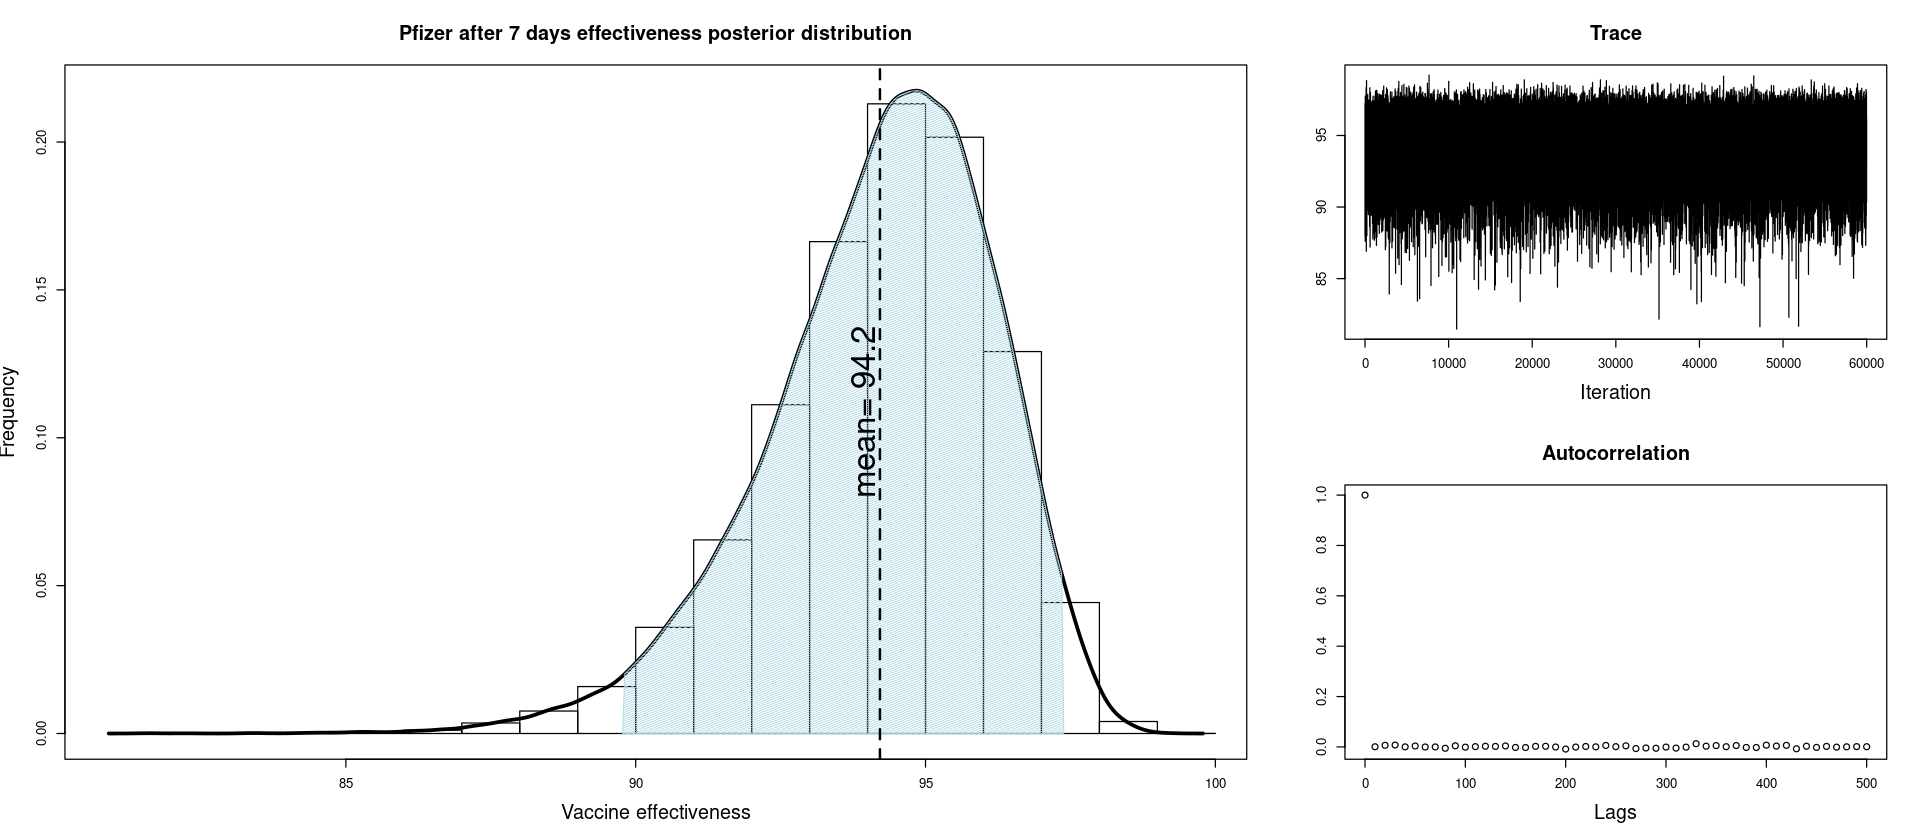

In [7]:
pfizer_old.chain <- infection_rate.mc(pfizer.df['tot_old',], iter=15000, n.chains=4, burnin=4000)
pfizer_old.eff   <- effectiveness(pfizer_old.chain, title='Pfizer after 7 days', color='lightblue')

#### Comirnaty (Pfizer/BioNTech): vaccine efficacy evaluated 6 months after the 2nd dose

Pfizer after 6 months effectiveness statistics:
Mean:			 90.71684
Mode:			 91.02429
Median:			 90.76969
Stdev:			 1.091935
95 cred. interval:	 88.45066 	 92.72931

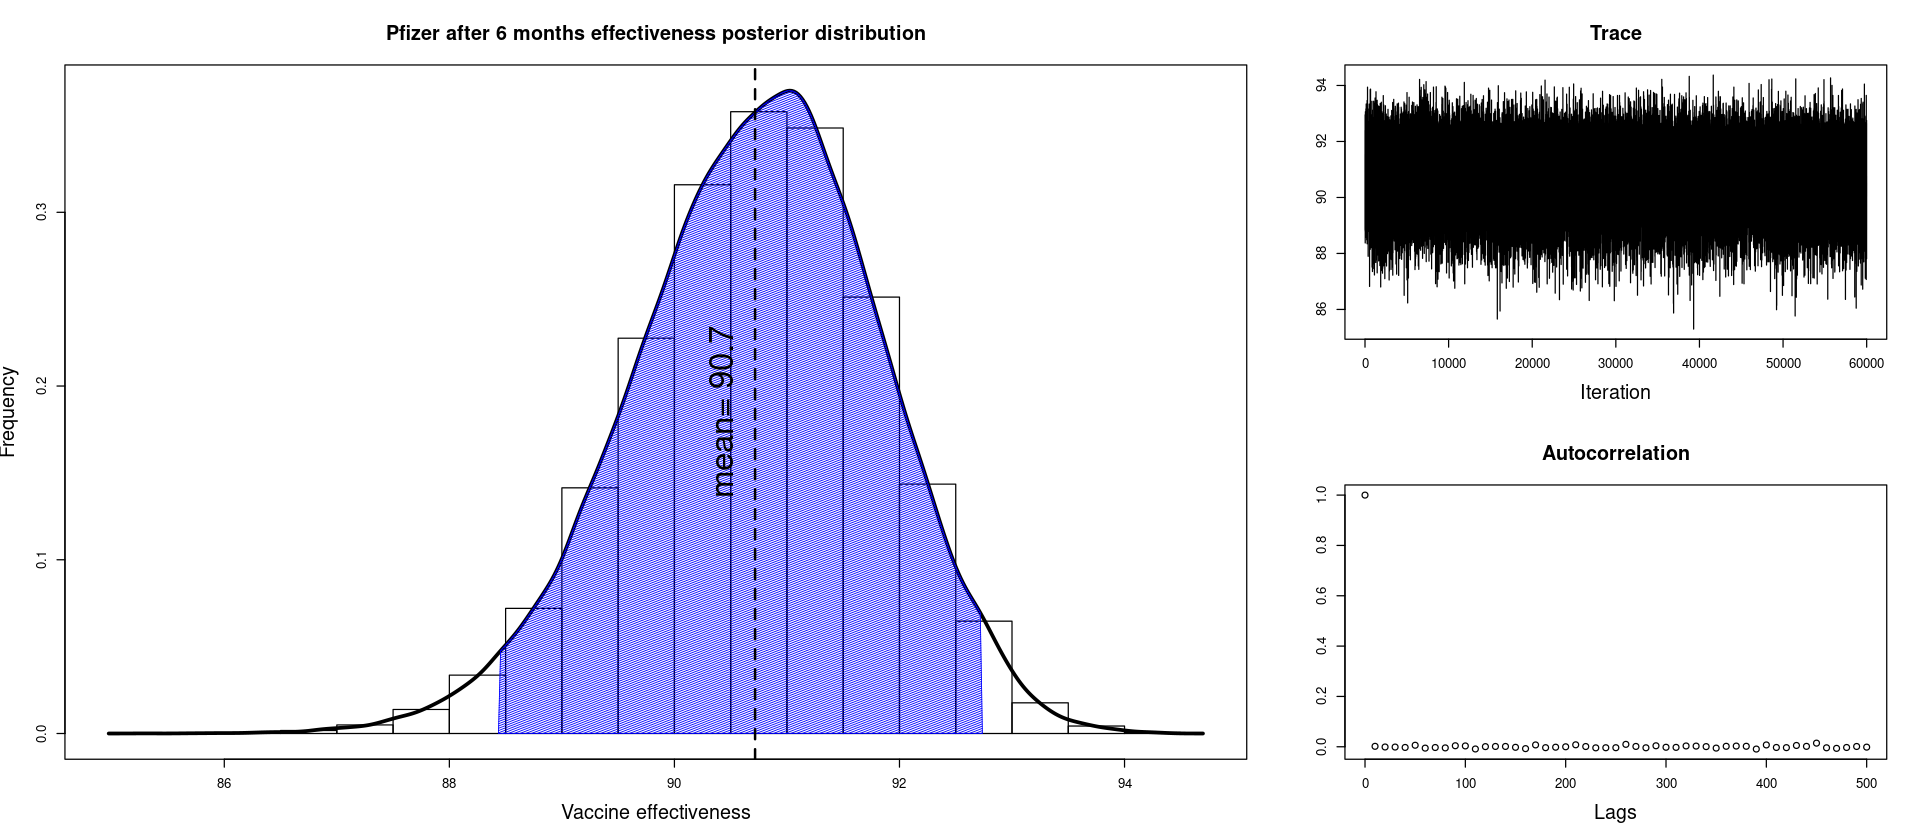

In [8]:
pfizer_new.chain <- infection_rate.mc(pfizer.df['tot_new',], iter=15000, n.chains=4, burnin=4000)
pfizer_new.eff   <- effectiveness(pfizer_new.chain, title='Pfizer after 6 months', color='blue')

#### Moderna: vaccine efficacy evaluated 14 days after the 2nd dose

Moderna after 14 days effectiveness statistics:
Mean:			 93.3747
Mode:			 93.89892
Median:			 93.56888
Stdev:			 1.947068
95 cred. interval:	 89.03274 	 96.61074

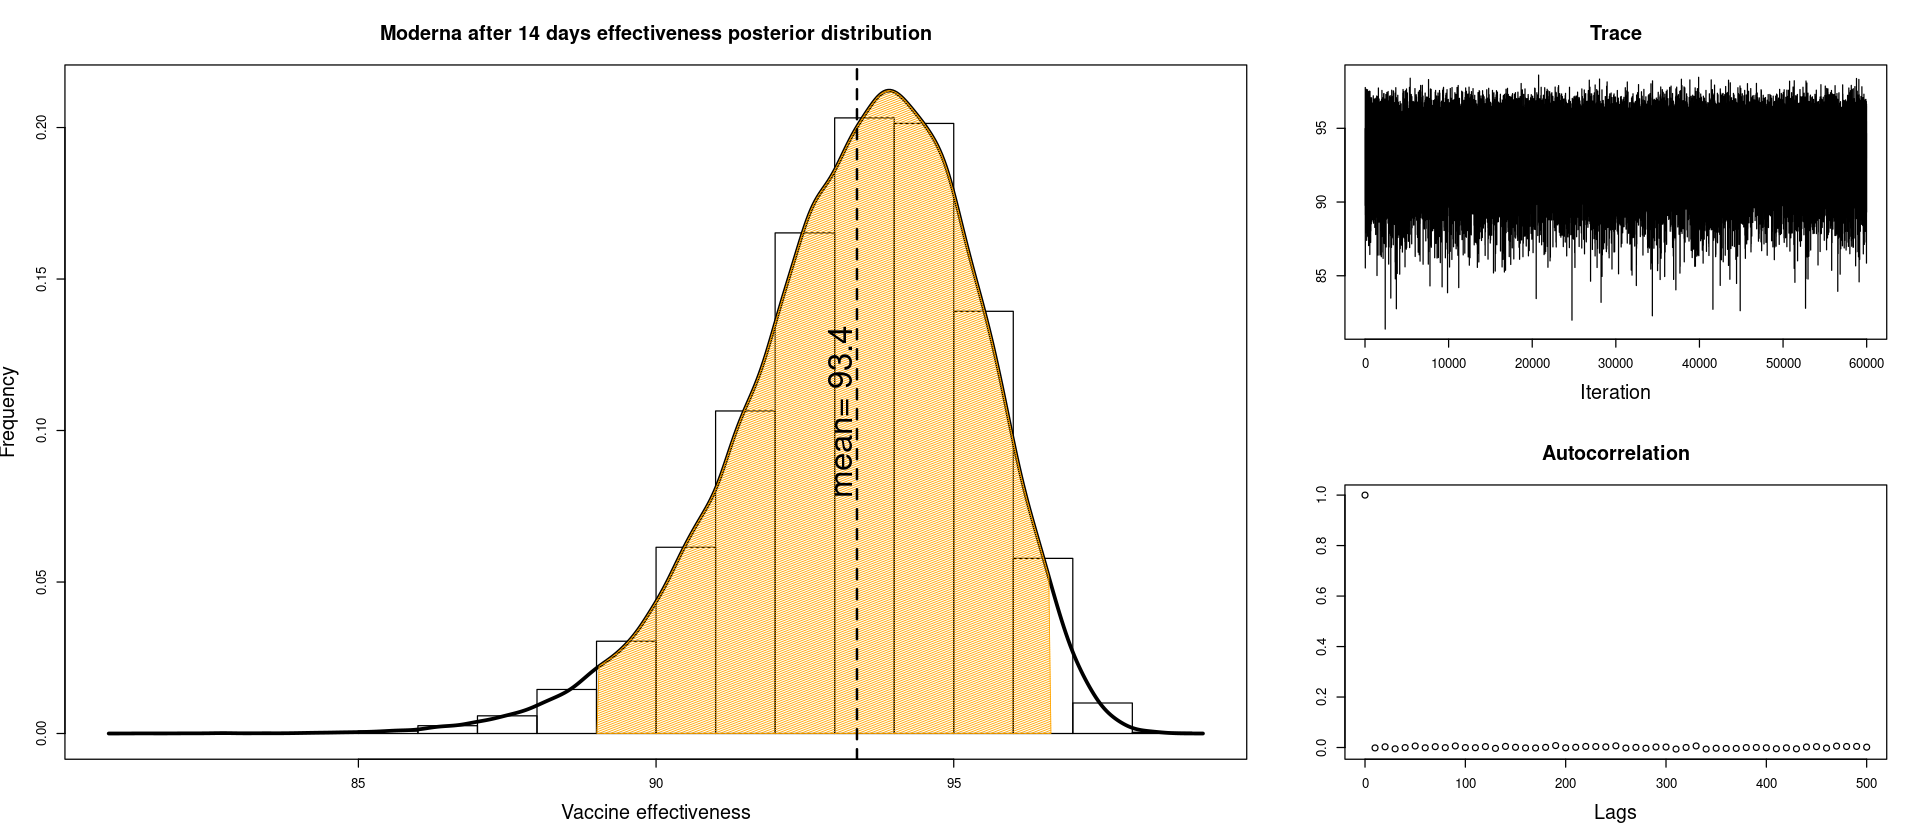

In [9]:
moderna.chain <- infection_rate.mc(moderna.df['tot',], iter=15000, n.chains=4, burnin=4000)
moderna.eff   <- effectiveness(moderna.chain, title='Moderna after 14 days', color='orange')

#### Vaxzevria: vaccine efficacy evaluated 14 days after the 2nd dose

Vaxzevria after 14 days effectiveness statistics:
Mean:			 65.78172
Mode:			 66.68421
Median:			 65.99589
Stdev:			 4.26234
95 cred. interval:	 56.79138 	 73.50355

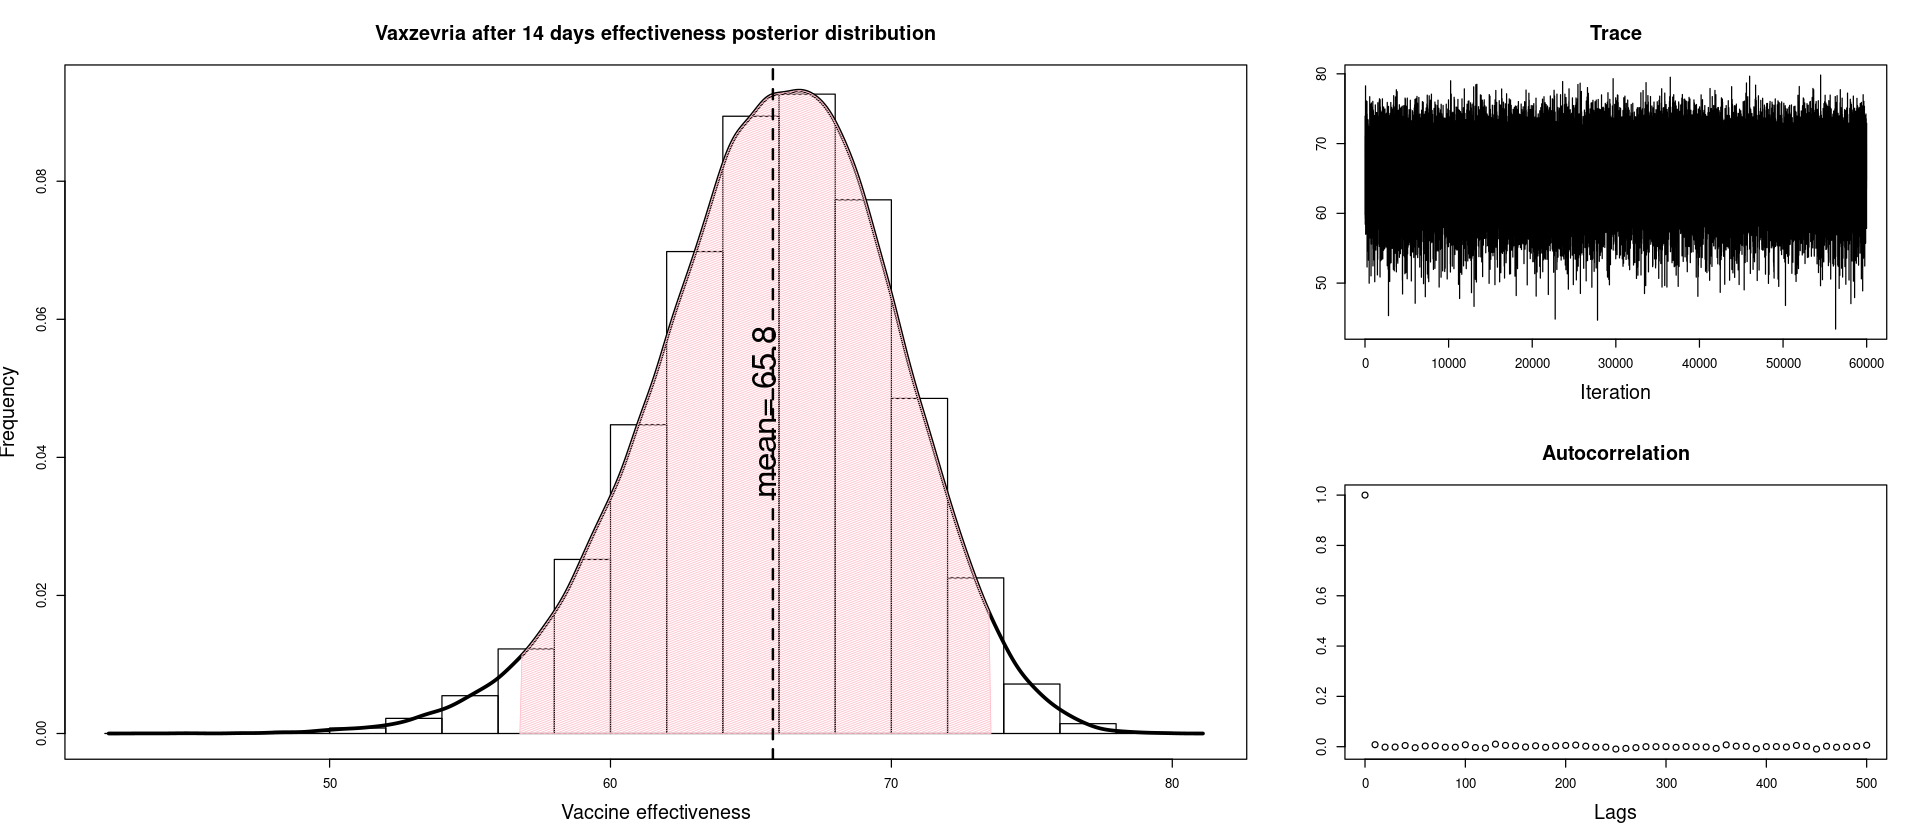

In [10]:
vaxzevria.chain <- infection_rate.mc(vaxz.df['tot',], iter=15000, n.chains=4, burnin=4000)
vaxzevria.eff   <- effectiveness(vaxzevria.chain, title='Vaxzevria after 14 days', color='pink')

#### Janssen: vaccine efficacy evaluated 14 days after the 2nd dose

Janssen after 14 days effectiveness statistics:
Mean:			 66.30502
Mode:			 66.72998
Median:			 66.47284
Stdev:			 3.600925
95 cred. interval:	 58.80866 	 72.88431

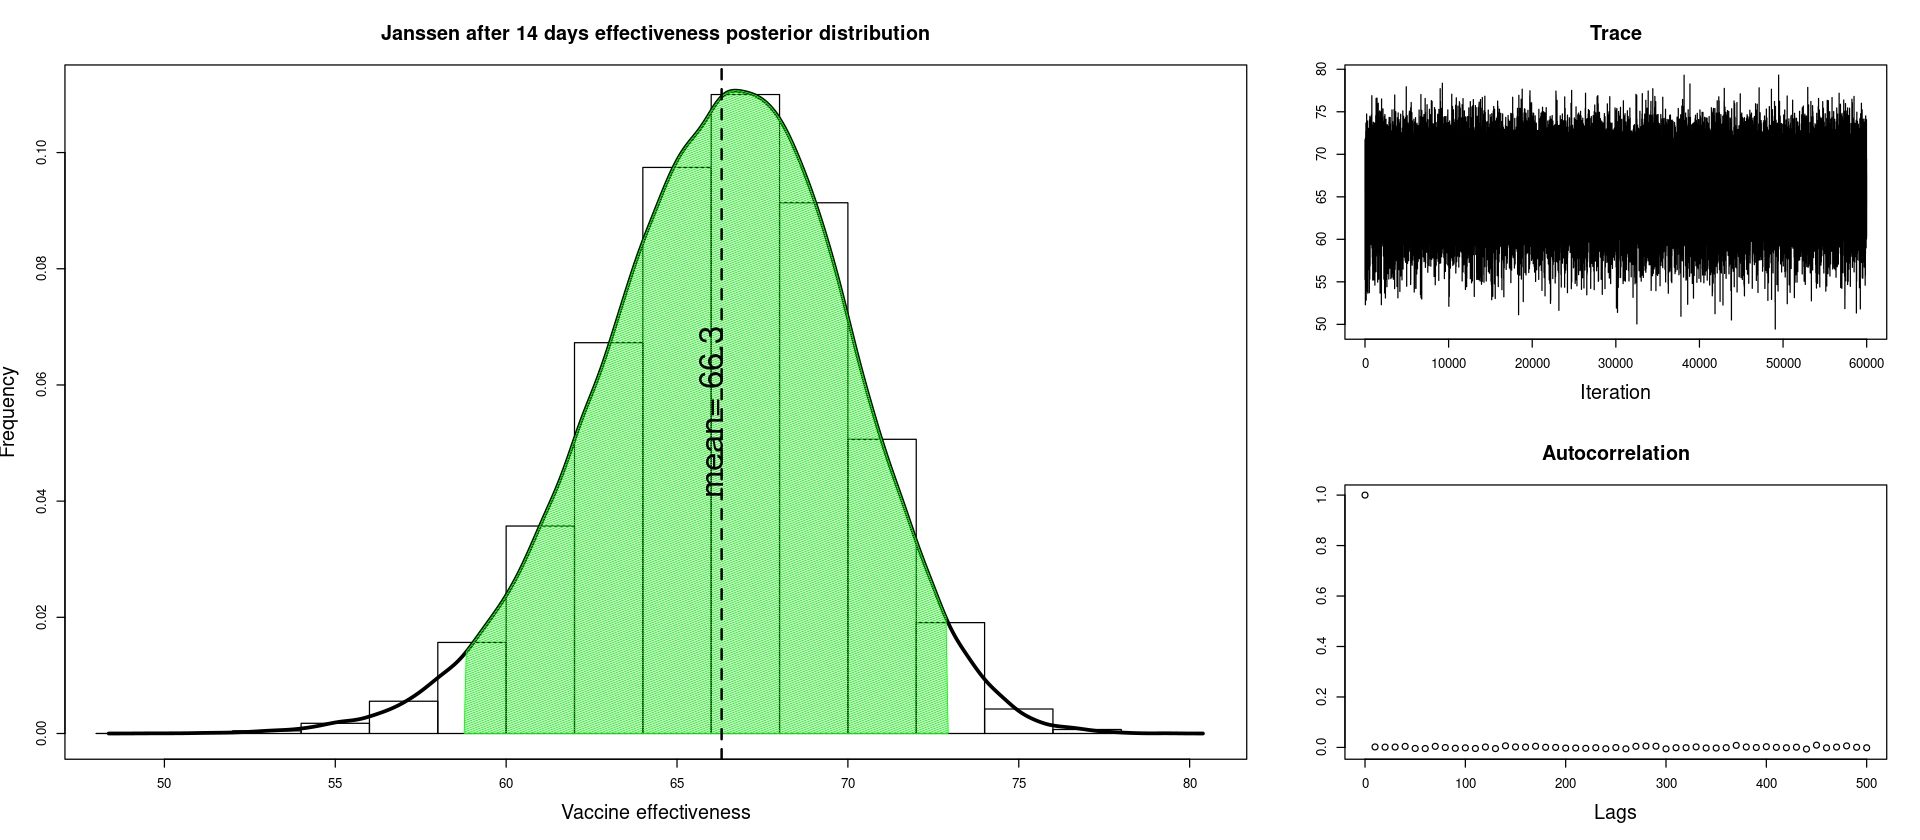

In [11]:
janssen.chain <- infection_rate.mc(janssen.df['tot',], iter=15000, n.chains=4, burnin=4000)
janssen.eff   <- effectiveness(janssen.chain, title='Janssen after 14 days', color='green')

### Effectiveness comparison among vaccines
***

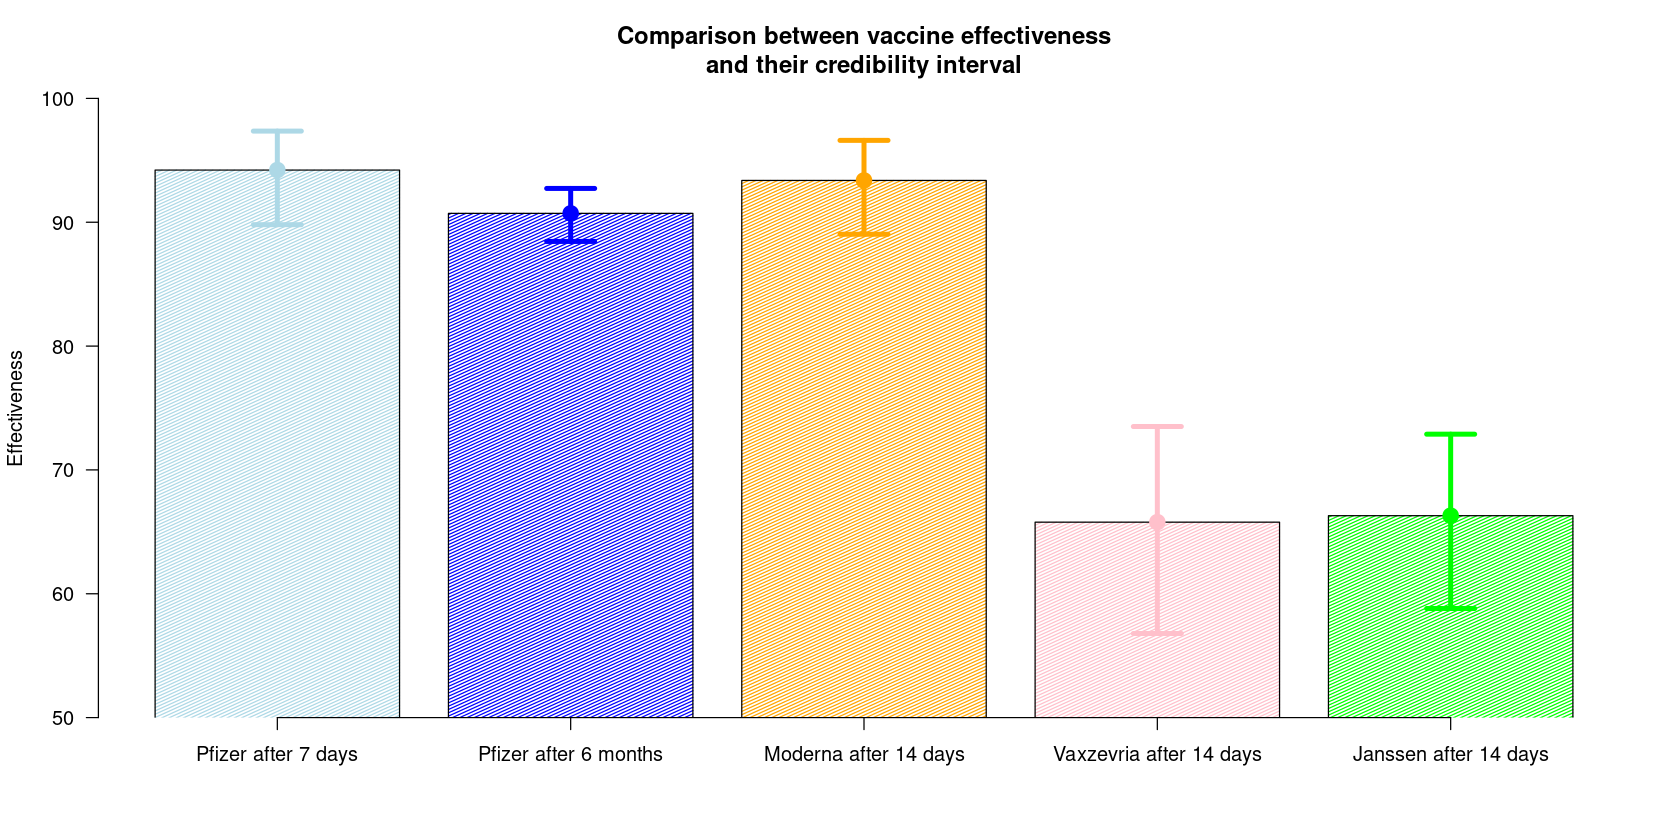

In [12]:
listoflist <- list(pfizer_old.eff, pfizer_new.eff, moderna.eff, vaxzevria.eff, janssen.eff)
eff_comparator(listoflist)

## Inference of the effectiveness as a function of age
***
#### Comirnaty (Pfizer/BioNTech): vaccine efficacy evaluated after 7 days from second dose, by age

In [13]:
pfizer12.chain <- infection_rate.mc(pfizer.df['12-15',], iter=15000, n.chains=4, burnin=4000)
pfizer12.eff   <- effectiveness(pfizer12.chain, title='12-15', color='lightblue', plot=FALSE)
pfizer16.chain <- infection_rate.mc(pfizer.df['16-64',], iter=15000, n.chains=4, burnin=4000)
pfizer16.eff   <- effectiveness(pfizer16.chain, title='16-64', color='lightblue', plot=FALSE)
pfizer65.chain <- infection_rate.mc(pfizer.df['65-74',], iter=15000, n.chains=4, burnin=4000)
pfizer65.eff   <- effectiveness(pfizer65.chain, title='65-74', color='lightblue', plot=FALSE)
pfizer75.chain <- infection_rate.mc(pfizer.df['more75',], iter=15000, n.chains=4, burnin=4000)
pfizer75.eff   <- effectiveness(pfizer75.chain, title='75-', color='lightblue', plot=FALSE)

pfizer.list = list(pfizer12.eff, pfizer16.eff, pfizer65.eff, pfizer75.eff)
pf.data = table.maker(pfizer.list)

		Mean		Mode		Median		Stdev		2.5cred		97.5cred	

12-15		92.7777		97.9698		94.5354		6.42343		76.0563		99.575
16-64		94.1382		94.8986		94.3855		2.08721		89.3638		97.4417
65-74		84.4531		91.8208		87.0596		11.0292		56.5193		97.7807
75-		78.6121		94.3831		84.8514		21.4026		21.7528		98.837

#### Moderna: vaccine efficacy evaluated after 14 days from second dose, by age

In [19]:
moderna12.chain <- infection_rate.mc(moderna.df['12-17',], iter=15000, n.chains=4, burnin=4000)
moderna12.eff   <- effectiveness(moderna12.chain, title='12-17', color='lightblue', plot=FALSE)
moderna18.chain <- infection_rate.mc(moderna.df['18-64',], iter=15000, n.chains=4, burnin=4000)
moderna18.eff   <- effectiveness(moderna18.chain, title='18-64', color='lightblue', plot=FALSE)
moderna65.chain <- infection_rate.mc(moderna.df['more65',], iter=15000, n.chains=4, burnin=4000)
moderna65.eff   <- effectiveness(moderna65.chain, title='65-', color='lightblue', plot=FALSE)

moderna.list = list(moderna12.eff, moderna18.eff, moderna65.eff)
mo.data = table.maker(moderna.list)

		Mean		Mode		Median		Stdev		2.5cred		97.5cred	

12-17		87.3919		97.0494		91.1966		12.8687		53.1466		99.357
18-64		94.6747		95.3983		94.902		1.88861		90.3438		97.7
65-		82.4832		86.8036		83.9542		8.30965		62.4987		94.4428

#### Janssen: vaccine efficacy evaluated after 14 days from second dose, by age

In [15]:
janssen18.chain <- infection_rate.mc(janssen.df['18-59',], iter=15000, n.chains=4, burnin=4000)
janssen18.eff   <- effectiveness(janssen18.chain, title='18-59', color='lightblue', plot=FALSE)
janssen60.chain <- infection_rate.mc(janssen.df['more60',], iter=15000, n.chains=4, burnin=4000)
janssen60.eff   <- effectiveness(janssen60.chain, title='60-', color='lightblue', plot=FALSE)

janssen.list = list(janssen18.eff, janssen60.eff)
ja.data = table.maker(janssen.list)

		Mean		Mode		Median		Stdev		2.5cred		97.5cred	

18-59		62.9821		64.1431		63.2181		4.3897		53.7702		70.9696
60-		74.9454		76.9535		75.458		5.90578		61.7996		84.9354

### Effectiveness comparison among vaccines, by age
***

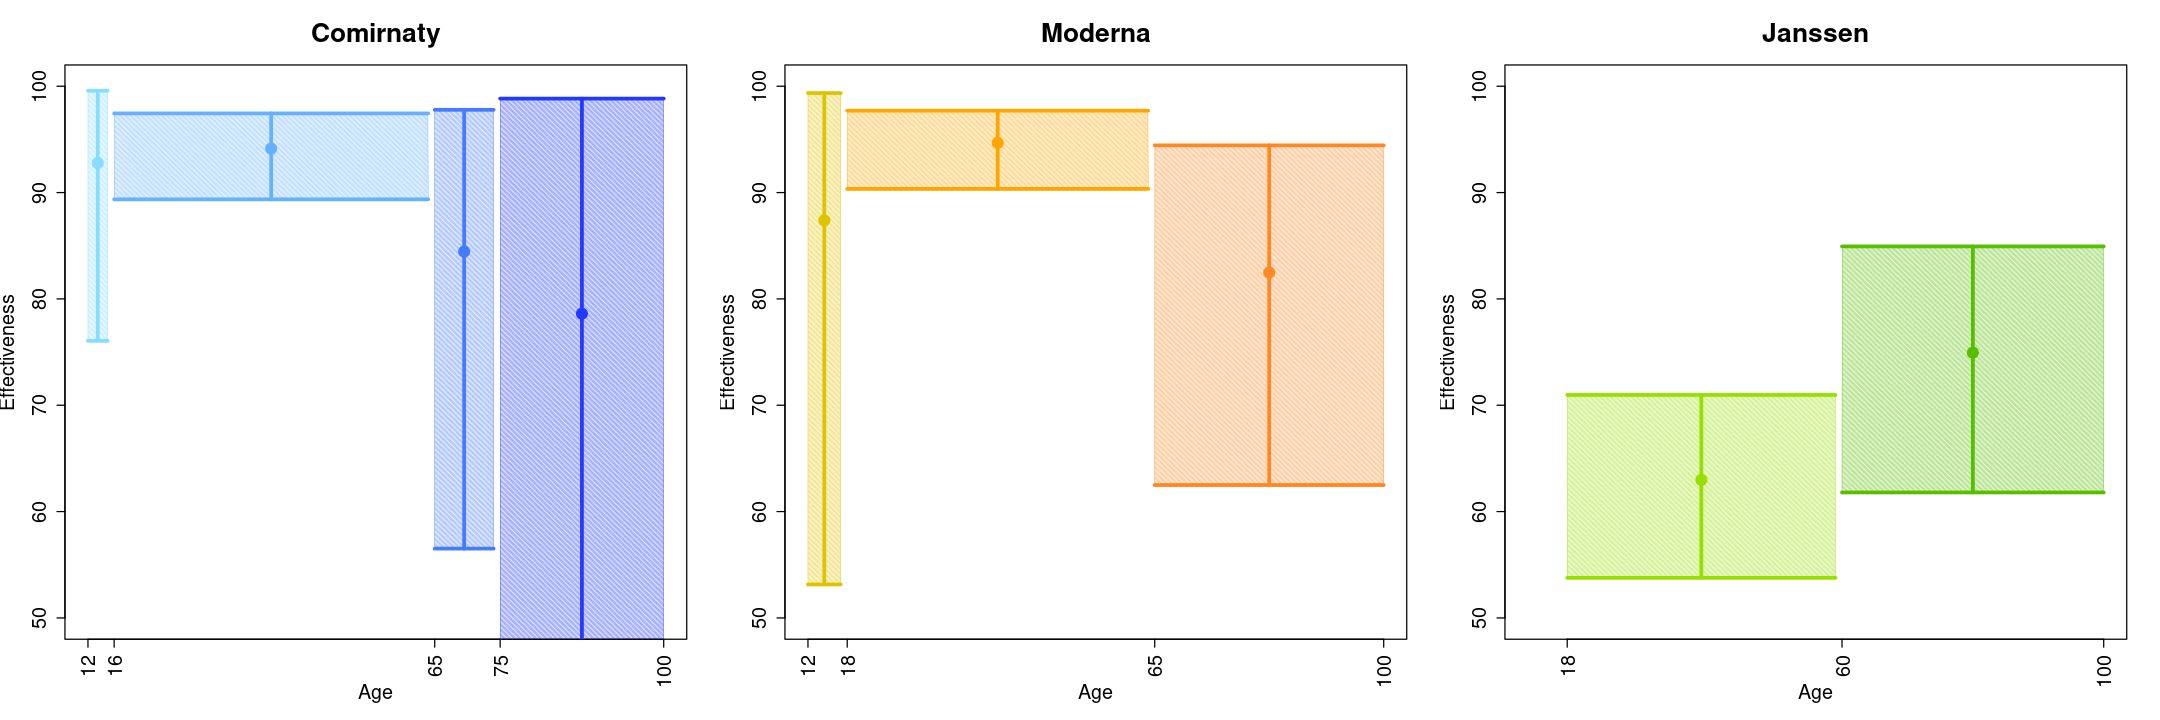

In [20]:
options(repr.plot.width=18, repr.plot.height=6)
par(mfrow=c(1,3))
age.comparator(pf.data, color=c('#88DCFF','#66B1FF','#447BFF','#223AFF'), 'Comirnaty')
age.comparator(mo.data, color=c('#DFC300','#FFA500','#FF8822'), 'Moderna')
age.comparator(ja.data, color=c('#97DF00','#57BF00'), 'Janssen')

## Conclusions
***
The obtained vaccine efficacies are similar to the ones shown in the official reports: a slight difference may be noticeable on the decimal digits, probably because of our prior choice. 
Further studies can be performed on the other vaccines that are being distributed around the world (Chinese Sinovac and Russian Sputnik V, for example). 

Lately in Italy some issues with adverse reactions to Vaxzevria vaccine have occurred: the government has included the possibility of receiving Comirnaty as second dose for who has received a single dose of Vaxzevria. Effectiveness data are not available yet.

## Appendix
***

### Model comparison
***

Here we show another method we studied to infer the effectiveness of the vaccines.
It differs from the JAGS method in the generation of the samples of the infection rate of the subjects who got placebo or vaccine.

Due to the fact that our $Beta(\alpha,\beta)$ prior is a conjugate priors for a binomial likelihood, with $n$ trials and $y$ successes, the analytical expression for the posterior distribution is:

$$
Beta(\alpha + y, \beta +n -y)
$$

Using the `R` built-in function `rbeta` we drew 100000 random samples from both placebo and vaccine infection rate posterior distributions. 

In [17]:
post_rand = function(title = 'Pfizer', posvac = pfizer.df['tot_old', 'vpos'], 
                     totvac = pfizer.df['tot_old', 'vtot'], pospla = pfizer.df['tot_old', 'ppos'], 
                     totpla = pfizer.df['tot_old', 'ptot'], ap = c(2.88,1.41), bp = c(93.12,66.11))
{   a1 = ap[2] + posvac
    a2 = ap[1] + pospla
    b1 = bp[2] + totvac - posvac
    b2 = bp[1] + totpla - pospla
    
    set.seed(1234)
    vrate = rbeta(10**5, a1, b1)
    set.seed(1234)
    prate = rbeta(10**5, a2, b2)
    veff = (prate - vrate)*100/prate
    
    stat <- NULL
    stat$density <- density(veff)
    stat$mode = stat$density$x[which.max(stat$density$y)]
    stat$mean = mean(veff)
    stat$median = median(veff)
    stat$sd = sd(veff)
    stat$cred.95 = quantile(veff, probs=c(0.025, 0.975))
    return(stat)
}

method.comparator = function(listoflist) {
    age.list = list(range = c(), mean = c(), cred2.5 = c(), cred97.5 = c(), x=c())
    cat('\t\tMean\t\tMode\t\tMedian\t\tStdev\t\t2.5cred\t\t97.5cred\t\n')
    tmp <- 1
    for (i in listoflist) {
        cat('\n', names(listoflist)[tmp], '\t\t', f(i$mean), '\t\t', f(i$mode), '\t\t', f(i$median),  
            '\t\t', f(i$sd), '\t\t', f(i$cred.95[[1]]), '\t\t', f(i$cred.95[[2]]), sep='')
        tmp <- tmp+1
        }
    options(repr.plot.width=14, repr.plot.height=7)
    plot(listoflist$jags$density$x, method.list$jags$density$y, type='l', col='red', lwd=2,
         main='Model comparison', ylab='Frequency', xlab='Effectiveness')
    a <- which(listoflist$jags$density$x > listoflist$jags$cred.95[[1]])[1]
    b <- which(listoflist$jags$density$x > listoflist$jags$cred.95[[2]])[1]-1
    polygon(listoflist$jags$density$x[(a-1):(b+1)], c(0,listoflist$jags$density$y[a:b],0), 
            col='red', density=60, lwd=0.7)
    lines(listoflist$alt$density$x, method.list$alt$density$y, col='blue', lwd=2)
    a <- which(listoflist$alt$density$x > listoflist$alt$cred.95[[1]])[1]
    b <- which(listoflist$alt$density$x > listoflist$alt$cred.95[[2]])[1]-1
    polygon(listoflist$alt$density$x[(a-1):(b+1)], c(0,listoflist$alt$density$y[a:b],0), 
            col='blue', density=30, lwd=.7)
    legend('topleft', cex=1.5, legend=c('JAGS','Alternative method'), col=c('red','blue'),
           lwd=2)
    grid()
}

		Mean		Mode		Median		Stdev		2.5cred		97.5cred	

jags		94.2136		94.8361		94.4442		1.95085		89.8017		97.3589
alt		94.2076		94.7431		94.4331		1.94019		89.8124		97.3345

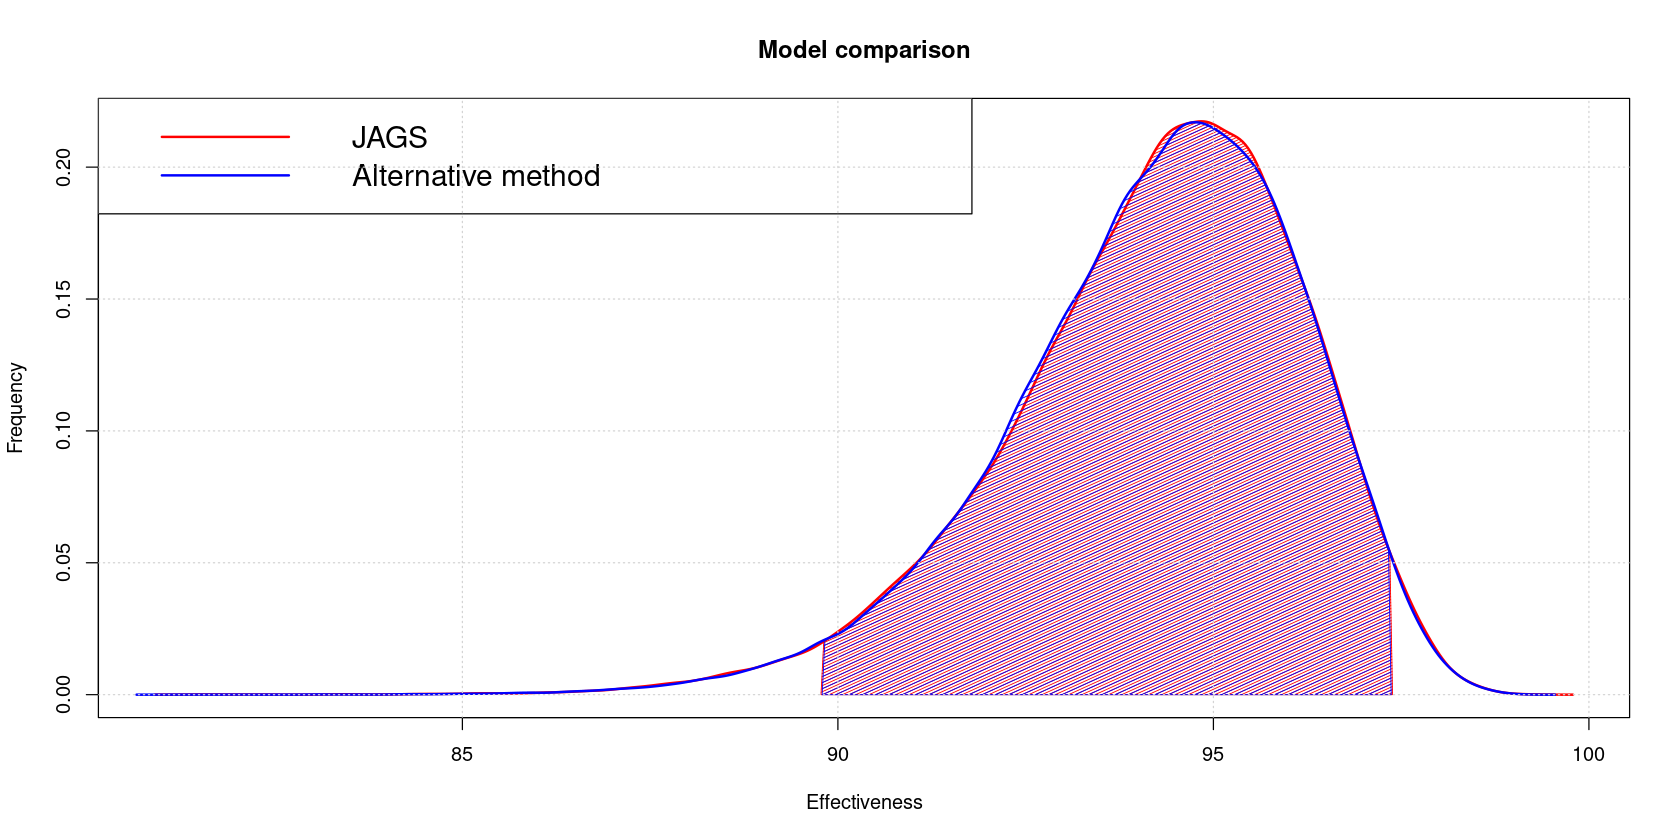

In [18]:
method.list <- list(jags=pfizer_old.eff, alt=post_rand())
method.comparator(method.list)

As we can see above with the two methods we obtain pretty much the same results.
In our case, in order to remain coherent to the fist part approach, we have performed the age analysis with JAGS method again.
It is noticeable that the alternative method is much less computationally intensive so it could be used in other scenarios like this one, where the analytical expression of the posterior distribution is known.

## Bibliography
***
- Slides of Advanced Statistics for Physics Analysis course (Prof. Garfagnini), Padua University, academic year 2020/2021
- https://ourworldindata.org/covid-vaccinations
- https://en.wikipedia.org/wiki/History_of_COVID-19_vaccine_development
- https://en.wikipedia.org/wiki/COVID-19_pandemic#2020
- https://www.ema.europa.eu/en/medicines/human/EPAR/comirnaty
- https://www.ema.europa.eu/en/medicines/human/EPAR/covid-19-vaccine-moderna
- https://www.ema.europa.eu/en/medicines/human/EPAR/vaxzevria-previously-covid-19-vaccine-astrazeneca
- https://www.ema.europa.eu/en/medicines/human/EPAR/covid-19-vaccine-janssen